<a href="https://colab.research.google.com/github/ivanyi031/AOI_final-project/blob/main/PCB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
print(torch.cuda.get_device_name())

Tesla T4


In [ ]:
import gdown

!gdown --id '1PFesymCit_uf9eDC8mK3LVT3uXC8y01V' --output Defect_data.zip
!unzip -q Defect_data.zip

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1PFesymCit_uf9eDC8mK3LVT3uXC8y01V
To: /content/Defect_data.zip
100% 34.6M/34.6M [00:00<00:00, 262MB/s]
replace Defect_data/missing_hole/1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import cv2
from PIL import Image
# "ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning.
from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset
from torchvision.datasets import DatasetFolder, ImageFolder

import matplotlib.pyplot as plt
# This is for the progress bar.
from tqdm.auto import tqdm
import time
import itertools

In [ ]:
train_tfm = transforms.Compose([
    # TODO: Add data augmentation for training data
    transforms.Resize((224, 224)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.RandomGrayscale(p=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation((0,180)),
    transforms.ToTensor(),

])

# No need augmentation on validation data
test_tfm = transforms.Compose([
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [ ]:
from torch.utils.data.dataset import random_split


PCB_set = ImageFolder("Defect_data", loader=lambda x:Image.open(x))
# Split dataset into training dataset and validation dataset
train_len = int(0.8 * len(PCB_set))
test_len = len(PCB_set) - train_len


train_set, test_set = random_split(PCB_set, [train_len, test_len])


train_set.dataset.transform = train_tfm
test_set.dataset.transform = test_tfm

In [ ]:
batch_size = 64

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

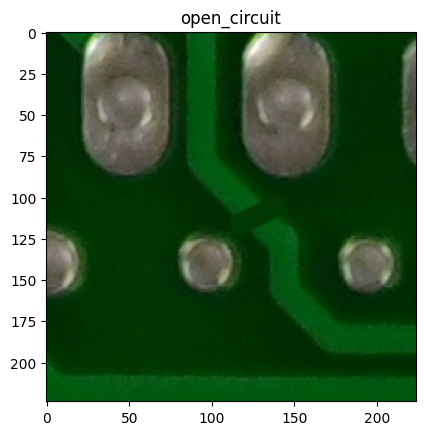

In [ ]:
label_sets = {
    0 : 'missing_hole',
    1 : 'mouse_bite',
    2 : 'open_circuit',
    3 : 'short',

}
img, label = next(iter(train_loader))
img = transforms.ToPILImage()(img[0]).convert('RGB')
plt.title(label_sets[int(label[0])])
plt.imshow(img)

In [ ]:
class Classifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.cnn_layers = nn.Sequential(
        # Input shape[3, 224, 224]
        # TODO: CNN layers
        #nn.Conv2d(input, output, kernelsize, stride, padding)
        nn.Conv2d(3, 64, 3, 1, 1),#output shape(64, 224, 224 )
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2, 2, 0),#output shape(64, 112, 112 )

        nn.Conv2d(64, 128, 3, 1, 1),#output shape(128, 112, 112 )
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(2, 2, 0),#output shape(128, 56, 56 )

        nn.Conv2d(128, 256, 3, 1, 1),#output shape(256, 56 56 )
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(2, 2, 0),#output shape(256, 28, 28 )

        nn.Conv2d(256,256, 3, 1, 1),#output shape(128, 28, 28 ),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(2, 2, 0),#output shape(256, 14, 14 )

        nn.Conv2d(256,512, 3, 1, 1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.MaxPool2d(2, 2, 0),#output shape(512, 7, 7 )

    )

    self.fc_layers = nn.Sequential(
        # TODO: Fully connected layer
        nn.Linear(512 * 7 * 7, 256),
        #torch.nn.Dropout(0.),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Linear(32, 9),
    )

  def forward(self, x):
    x = self.cnn_layers(x)

    # The extracted feature map must be flatten before going to fully-connected layers.
    x = torch.flatten(x, 1)

    x = self.fc_layers(x)
    return x

In [ ]:
import gc
# Set the random seed.
seed = 0
torch.manual_seed(seed)
if(torch.cuda.is_available()):
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

# Initialize a model, and put it on the device specified.
model = Classifier().to(device)
model.device = device

# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=0.003, weight_decay=0.0001)

# The number of training epochs.
epoch_num = 60

# Initialize learning rate scheduler
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.97)

valid_acc = 0.0
train_acc_history = []
train_loss_history = []
valid_acc_history = []
valid_loss_history = []
for epoch in range(epoch_num):
  model.train()
  # These are used to record information in training.
  train_loss = []
  train_accs = []

  for batch in tqdm(train_loader):

    imgs, labels = batch

    # Forward the data. (Make sure data and model are on the same device.)
    gc.collect()
    torch.cuda.empty_cache()


    logits = model(imgs.to(device))

    # Calculate the cross-entropy loss.
    # We don't need to apply softmax before computing cross-entropy as it is done automatically.
    loss = criterion(logits, labels.to(device))

    # Gradients stored in the parameters in the previous step should be cleared out first.
    optimizer.zero_grad()

    # Compute the gradients for parameters.
    loss.backward()

    # Clip the gradient norms for stable training.
    grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

    # Update the parameters with computed gradients.
    optimizer.step()

    # Compute the accuracy for current batch.
    acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

    # Record the loss and accuracy.
    train_loss.append(loss.item())
    train_accs.append(acc.item())

  # The average loss and accuracy of the training set is the average of the recorded values.
  #scheduler.step()
  train_loss = sum(train_loss) / len(train_loss)
  train_accs = sum(train_accs) / len(train_accs)
  train_acc_history.append(train_accs)
  train_loss_history.append(train_loss)

  # Print the information.
  print(f"[ Train | {epoch + 1:03d}/{epoch_num:03d} ] loss = {train_loss:.5f}, acc = {acc:.5f}")

  # ---------- Validation ----------
  # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
  model.eval()

  # These are used to record information in validation.

  # Iterate the validation set by batches.
  # for batch in tqdm(valid_loader):

  #     # A batch consists of image data and corresponding labels.
  #     imgs, labels = batch

  #     # We don't need gradient in validation.
  #     # Using torch.no_grad() accelerates the forward process.
  #     with torch.no_grad():
  #       logits = model(imgs.to(device))
  #       y_pred.append(logits)
  #     # We can still compute the loss (but not the gradient).
  #     y_test.append(labels.to(device))
  #     loss = criterion(logits, labels.to(device))

  #     # Compute the accuracy for current batch.
  #     acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

  #     # Record the loss and accuracy.
  #     valid_loss.append(loss.item())
  #     valid_accs.append(acc)
  valid_loss = []
  valid_accs = []
  y_pred = []
  y_test = []
  def validate(valid_loader, model, criterion, device, y_pred, y_test):
    model.eval()
    with torch.no_grad():
        end = time.time()
        for i, (images, labels) in enumerate(test_loader):
            # if device.gpu is not None:
            #     images = images.cuda(device.gpu, non_blocking=True)
            # if torch.cuda.is_available():
            #     target = target.cuda(device.gpu, non_blocking=True)
            #inputs, labels = data                         # this is what you had
            images, labels = images.cuda(), labels.cuda() # add this line
            output = model(images)
            _, preds = torch.max(output, 1)                            # preds是預測結果
            loss = criterion(output, labels)
            acc = (output.argmax(dim=-1) == labels.to(device)).float().mean()

            y_pred.extend(preds.view(-1).detach().cpu().numpy())       # 將preds預測結果detach出來，並轉成numpy格式
            y_test.extend(labels.view(-1).detach().cpu().numpy())      # target是ground-truth的label
            valid_loss.append(loss.item())
            valid_accs.append(acc.item())


    return y_pred, y_test ,valid_loss, valid_accs


  y_pred, y_test, valid_loss, valid_accs = validate(test_loader, model, criterion, device,  y_pred, y_test)

  # The average loss and accuracy for entire validation set is the average of the recorded values.
  valid_loss = sum(valid_loss) / len(valid_loss)
  valid_acc = sum(valid_accs) / len(valid_accs)
  valid_acc_history.append(valid_acc)
  valid_loss_history.append(valid_loss)

  # Print the information.
  print(f"[ Valid | {epoch + 1:03d}/{epoch_num:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")

cuda


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 001/060 ] loss = 1.81100, acc = 0.50000
[ Valid | 001/060 ] loss = 1.41394, acc = 0.26979


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 002/060 ] loss = 0.99917, acc = 0.46875
[ Valid | 002/060 ] loss = 1.60498, acc = 0.24896


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 003/060 ] loss = 0.91281, acc = 0.50000
[ Valid | 003/060 ] loss = 0.97963, acc = 0.46198


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 004/060 ] loss = 0.87201, acc = 0.62500
[ Valid | 004/060 ] loss = 0.84046, acc = 0.47292


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 005/060 ] loss = 0.87241, acc = 0.37500
[ Valid | 005/060 ] loss = 0.81579, acc = 0.50573


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 006/060 ] loss = 0.86198, acc = 0.46875
[ Valid | 006/060 ] loss = 0.87654, acc = 0.51042


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 007/060 ] loss = 0.88158, acc = 0.56250
[ Valid | 007/060 ] loss = 0.94273, acc = 0.51146


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 008/060 ] loss = 0.87686, acc = 0.46875
[ Valid | 008/060 ] loss = 0.87234, acc = 0.49688


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 009/060 ] loss = 0.85411, acc = 0.50000
[ Valid | 009/060 ] loss = 0.82339, acc = 0.47552


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 010/060 ] loss = 0.83908, acc = 0.65625
[ Valid | 010/060 ] loss = 0.82055, acc = 0.56615


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 011/060 ] loss = 0.82826, acc = 0.78125
[ Valid | 011/060 ] loss = 0.89221, acc = 0.55885


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 012/060 ] loss = 0.63900, acc = 0.84375
[ Valid | 012/060 ] loss = 3.36408, acc = 0.30990


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 013/060 ] loss = 0.54879, acc = 0.50000
[ Valid | 013/060 ] loss = 1.51984, acc = 0.46198


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 014/060 ] loss = 0.48151, acc = 0.68750
[ Valid | 014/060 ] loss = 0.52632, acc = 0.74635


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 015/060 ] loss = 0.42230, acc = 0.65625
[ Valid | 015/060 ] loss = 0.45165, acc = 0.81458


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 016/060 ] loss = 0.40923, acc = 0.84375
[ Valid | 016/060 ] loss = 0.48665, acc = 0.77917


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 017/060 ] loss = 0.31243, acc = 0.87500
[ Valid | 017/060 ] loss = 0.38725, acc = 0.84583


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 018/060 ] loss = 0.31443, acc = 0.93750
[ Valid | 018/060 ] loss = 0.30169, acc = 0.88698


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 019/060 ] loss = 0.23732, acc = 0.90625
[ Valid | 019/060 ] loss = 0.45934, acc = 0.81146


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 020/060 ] loss = 0.19458, acc = 0.96875
[ Valid | 020/060 ] loss = 0.28433, acc = 0.88750


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 021/060 ] loss = 0.11489, acc = 0.96875
[ Valid | 021/060 ] loss = 0.22042, acc = 0.93437


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 022/060 ] loss = 0.09650, acc = 0.90625
[ Valid | 022/060 ] loss = 0.16997, acc = 0.93437


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 023/060 ] loss = 0.08353, acc = 1.00000
[ Valid | 023/060 ] loss = 0.61429, acc = 0.79219


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 024/060 ] loss = 0.14361, acc = 0.90625
[ Valid | 024/060 ] loss = 0.28009, acc = 0.91458


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 025/060 ] loss = 0.13208, acc = 1.00000
[ Valid | 025/060 ] loss = 0.15077, acc = 0.94635


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 026/060 ] loss = 0.02785, acc = 1.00000
[ Valid | 026/060 ] loss = 0.13425, acc = 0.96198


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 027/060 ] loss = 0.02867, acc = 1.00000
[ Valid | 027/060 ] loss = 0.16490, acc = 0.95521


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 028/060 ] loss = 0.02771, acc = 1.00000
[ Valid | 028/060 ] loss = 0.27441, acc = 0.93281


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 029/060 ] loss = 0.03178, acc = 0.96875
[ Valid | 029/060 ] loss = 0.14651, acc = 0.94792


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 030/060 ] loss = 0.11069, acc = 1.00000
[ Valid | 030/060 ] loss = 0.21580, acc = 0.93958


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 031/060 ] loss = 0.03676, acc = 0.96875
[ Valid | 031/060 ] loss = 0.16525, acc = 0.95938


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 032/060 ] loss = 0.05207, acc = 1.00000
[ Valid | 032/060 ] loss = 0.23253, acc = 0.92813


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 033/060 ] loss = 0.04448, acc = 1.00000
[ Valid | 033/060 ] loss = 0.15778, acc = 0.95417


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 034/060 ] loss = 0.01322, acc = 1.00000
[ Valid | 034/060 ] loss = 0.13050, acc = 0.96562


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 035/060 ] loss = 0.00889, acc = 1.00000
[ Valid | 035/060 ] loss = 0.35574, acc = 0.93437


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 036/060 ] loss = 0.02514, acc = 1.00000
[ Valid | 036/060 ] loss = 0.35787, acc = 0.90104


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 037/060 ] loss = 0.04171, acc = 1.00000
[ Valid | 037/060 ] loss = 0.20390, acc = 0.94063


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 038/060 ] loss = 0.02546, acc = 1.00000
[ Valid | 038/060 ] loss = 0.14373, acc = 0.96719


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 039/060 ] loss = 0.05689, acc = 1.00000
[ Valid | 039/060 ] loss = 0.14736, acc = 0.96615


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 040/060 ] loss = 0.04294, acc = 0.96875
[ Valid | 040/060 ] loss = 0.15568, acc = 0.95677


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 041/060 ] loss = 0.01654, acc = 0.96875
[ Valid | 041/060 ] loss = 0.11107, acc = 0.96979


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 042/060 ] loss = 0.03866, acc = 1.00000
[ Valid | 042/060 ] loss = 0.32026, acc = 0.92969


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 043/060 ] loss = 0.01675, acc = 1.00000
[ Valid | 043/060 ] loss = 0.12596, acc = 0.96562


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 044/060 ] loss = 0.03897, acc = 1.00000
[ Valid | 044/060 ] loss = 0.12239, acc = 0.96979


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 045/060 ] loss = 0.03349, acc = 0.96875
[ Valid | 045/060 ] loss = 0.17529, acc = 0.95260


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 046/060 ] loss = 0.01158, acc = 1.00000
[ Valid | 046/060 ] loss = 0.13588, acc = 0.97083


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 047/060 ] loss = 0.01659, acc = 1.00000
[ Valid | 047/060 ] loss = 0.14852, acc = 0.96302


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 048/060 ] loss = 0.03829, acc = 0.96875
[ Valid | 048/060 ] loss = 0.32181, acc = 0.92344


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 049/060 ] loss = 0.03277, acc = 1.00000
[ Valid | 049/060 ] loss = 0.18739, acc = 0.94688


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 050/060 ] loss = 0.01577, acc = 1.00000
[ Valid | 050/060 ] loss = 0.13830, acc = 0.95625


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 051/060 ] loss = 0.00788, acc = 1.00000
[ Valid | 051/060 ] loss = 0.11164, acc = 0.98438


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 052/060 ] loss = 0.00519, acc = 1.00000
[ Valid | 052/060 ] loss = 0.18907, acc = 0.97604


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 053/060 ] loss = 0.00070, acc = 1.00000
[ Valid | 053/060 ] loss = 0.18261, acc = 0.97083


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 054/060 ] loss = 0.00054, acc = 1.00000
[ Valid | 054/060 ] loss = 0.11318, acc = 0.98177


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 055/060 ] loss = 0.00032, acc = 1.00000
[ Valid | 055/060 ] loss = 0.13821, acc = 0.97865


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 056/060 ] loss = 0.00021, acc = 1.00000
[ Valid | 056/060 ] loss = 0.13288, acc = 0.98021


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 057/060 ] loss = 0.00010, acc = 1.00000
[ Valid | 057/060 ] loss = 0.14874, acc = 0.98177


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 058/060 ] loss = 0.00006, acc = 1.00000
[ Valid | 058/060 ] loss = 0.20454, acc = 0.97865


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 059/060 ] loss = 0.00011, acc = 1.00000
[ Valid | 059/060 ] loss = 0.15428, acc = 0.98281


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 060/060 ] loss = 0.00007, acc = 1.00000
[ Valid | 060/060 ] loss = 0.19586, acc = 0.98021


In [ ]:
# Save the model
torch.save(model, "mymodel.pth")

from torchsummary import summary
summary(model.cuda(), (3, 224, 224))

from google.colab import files

#files.download('mymodel.pth')


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
         MaxPool2d-4         [-1, 64, 112, 112]               0
            Conv2d-5        [-1, 128, 112, 112]          73,856
       BatchNorm2d-6        [-1, 128, 112, 112]             256
              ReLU-7        [-1, 128, 112, 112]               0
         MaxPool2d-8          [-1, 128, 56, 56]               0
            Conv2d-9          [-1, 256, 56, 56]         295,168
      BatchNorm2d-10          [-1, 256, 56, 56]             512
             ReLU-11          [-1, 256, 56, 56]               0
        MaxPool2d-12          [-1, 256, 28, 28]               0
           Conv2d-13          [-1, 256, 28, 28]         590,080
      BatchNorm2d-14          [-1, 256,

In [ ]:
# util functions
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        # print("Normalized confusion matrix")
    else:
      pass
        # print('Confusion matrix, without normalization')

    # print(cm)
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    # plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Text(0.5, 0, 'epoch')

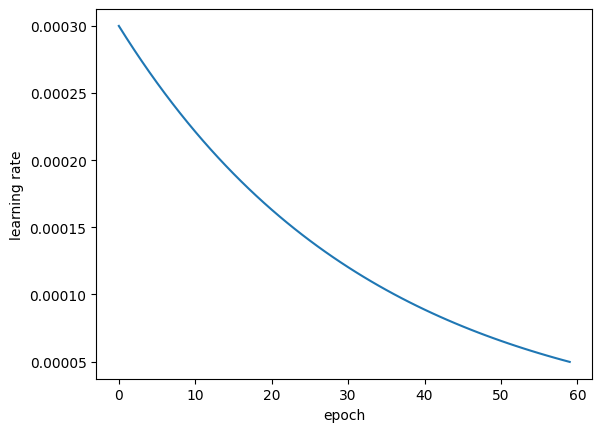

In [ ]:
learning_rate=[]
for i in range(60):
  learning_rate.append(0.0003*0.97**i)
plt.plot(learning_rate)
plt.ylabel('learning rate')
plt.xlabel('epoch')

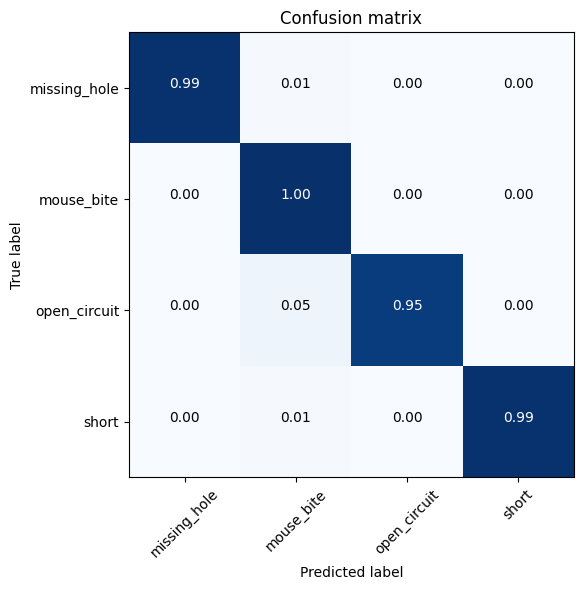

In [ ]:
from sklearn.metrics import confusion_matrix

classes = ['missing_hole',
    'mouse_bite',
    'open_circuit',
    'short',
    ]
matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(matrix, classes=classes, normalize=True)

In [ ]:
import matplotlib.pyplot as plt
def show_train_history(train_acc,valid_acc,ylabel):
    epoch = np.linspace(1,60,60)
    plt.plot(epoch, train_acc)
    plt.plot(epoch, valid_acc)
    plt.title('Train History')
    plt.ylabel(ylabel)
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

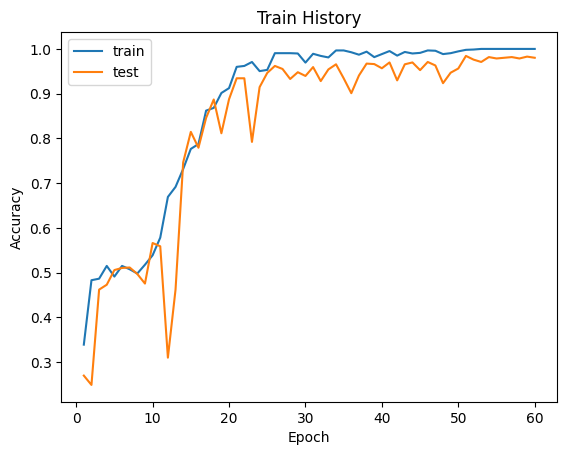

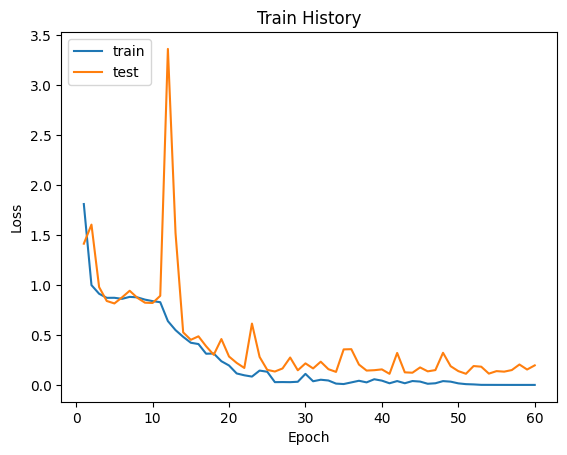

In [ ]:
show_train_history(train_acc_history,valid_acc_history,'Accuracy')
show_train_history(train_loss_history,valid_loss_history,'Loss')

tensor([0, 1, 0, 1, 2, 1, 1, 3, 3, 3])


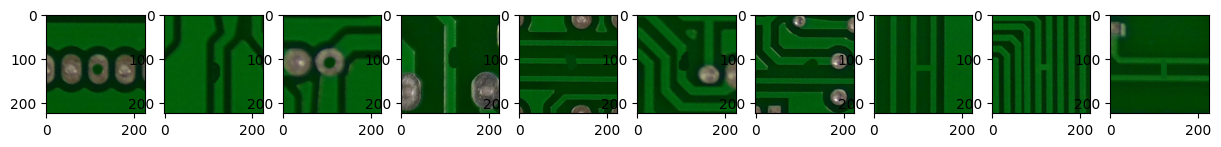

In [ ]:
# The images for observation
XAI_loader = DataLoader(test_set, batch_size=10, shuffle=True)

images, labels = next(iter(XAI_loader))
fig, axs = plt.subplots(1, len(images), figsize=(15, 8))
print(labels)
for i, img in enumerate(images):
  axs[i].imshow(img.cpu().permute(1, 2, 0))
  # axs[i].set_title(label_sets[int(labels[i])])

In [ ]:
class IntegratedGradients():
    def __init__(self, model):
        self.model = model
        self.gradients = None
        # Put model in evaluation mode
        self.model.eval()

    def generate_images_on_linear_path(self, input_image, steps):
        # Generate scaled xbar images
        xbar_list = [input_image*step/steps for step in range(steps)]
        return xbar_list

    def generate_gradients(self, input_image, target_class):
        # We want to get the gradients of the input image
        input_image.requires_grad=True
        # Forward
        model_output = self.model(input_image)
        # Zero grads
        self.model.zero_grad()
        # Target for backprop
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_().cuda()
        one_hot_output[0][target_class] = 1
        # Backward
        model_output.backward(gradient=one_hot_output)
        self.gradients = input_image.grad
        # Convert Pytorch variable to numpy array
        # [0] to get rid of the first channel (1,3,128,128)
        gradients_as_arr = self.gradients.data.cpu().numpy()[0]
        return gradients_as_arr

    def generate_integrated_gradients(self, input_image, target_class, steps):
        # Generate xbar images
        xbar_list = self.generate_images_on_linear_path(input_image, steps)
        # Initialize an iamge composed of zeros
        integrated_grads = np.zeros(input_image.size())
        for xbar_image in xbar_list:
            # Generate gradients from xbar images
            single_integrated_grad = self.generate_gradients(xbar_image, target_class)
            # Add rescaled grads from xbar images
            integrated_grads = integrated_grads + single_integrated_grad/steps
        # [0] to get rid of the first channel (1,3,128,128)
        return integrated_grads[0]

def normalize(image):
  return (image - image.min()) / (image.max() - image.min())

Future Map


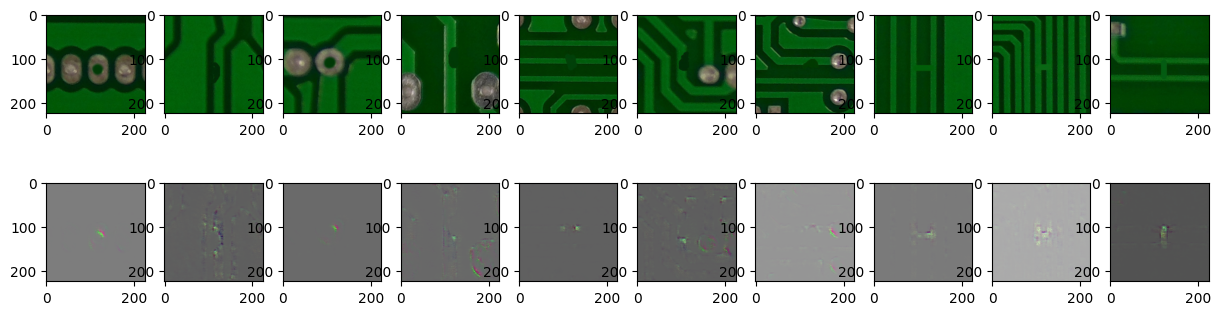

In [ ]:
# put the image to cuda
images = images.cuda()

IG = IntegratedGradients(model)
integrated_grads = []
for i, img in enumerate(images):
  img = img.unsqueeze(0)
  integrated_grads.append(IG.generate_integrated_gradients(img, labels[i], 1000))
fig, axs = plt.subplots(2, len(images), figsize=(15, 4))
for i, img in enumerate(images):
  axs[0][i].imshow(img.cpu().permute(1, 2, 0))
for i, img in enumerate(integrated_grads):
  axs[1][i].imshow(np.moveaxis(normalize(img),0,-1))
plt.show()
plt.close()

Testing


In [ ]:
def XOR_operation(tem,test_image):
    detect_set=[]
    Map=test_image.copy()
    detect_map = test_image.copy()
    Map[:,:,:]=0
    test_image1=cv2.adaptiveThreshold(cv2.cvtColor(test_image,cv2.COLOR_BGR2GRAY),255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,13,2)
    tem_image=cv2.adaptiveThreshold(cv2.cvtColor(tem,cv2.COLOR_BGR2GRAY),255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,13,2)
    defect= cv2.bitwise_xor(test_image1,tem_image)
    defect=cv2.medianBlur(defect,9)

    kernel_dilation=cv2.getStructuringElement(cv2.MORPH_RECT,(9,9))
    defect=cv2.morphologyEx(defect,cv2.MORPH_DILATE,kernel_dilation)
    kernel_close=cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))
    defect=cv2.morphologyEx(defect,cv2.MORPH_CLOSE,kernel_close)
    contours,hier=cv2.findContours(defect,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    defect[:100,:]=0
    detect_map[:100,:,:]=0
    x_c=[]
    y_c=[]
    for(index,contour) in  enumerate(contours):
        x, y, h, z = cv2.boundingRect(contours[index])
        if(np.sum(Map[y-64:y+64,x-64:x+64:,:])==0):
          # print("i=",i,"cordinate=",y,x)
          # print("sum=",np.sum(Map[y-64:y+64,x-64:x+64]))
          try:
            cv2.rectangle(detect_map,(x-64,y-64),(x+64,y+64),(0,0,255),3,cv2.LINE_AA)
            output = cv2.resize(test_image[y-64:y+64,x-64:x+64,:],(224,224),interpolation=cv2.INTER_AREA)
            detect_set.append(output)
            cv2.putText(detect_map,str(i),(x,y),cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,255),1,cv2.LINE_AA)
            x_c.append(x)
            y_c.append(y)
          except:
            pass

        Map[y-16:y+16,x-16:x+16]=255

    return(defect,detect_set,detect_map)

In [ ]:
from google.colab import drive

drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


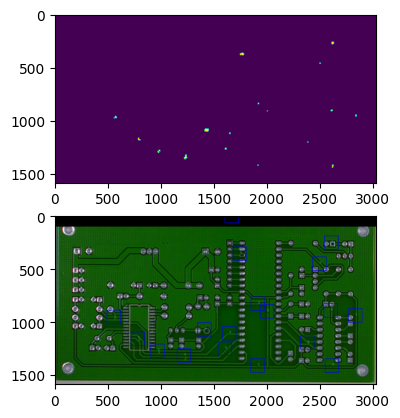

In [ ]:


template_path="/content/drive/MyDrive/PCB_used/01.JPG"
tem = cv2.imread(template_path)
test_path="/content/drive/MyDrive/PCB_test/01.jpg"
test_image = cv2.imread(test_path)
# for image in os.walk(test_path):
#     for names in image[2]:
#         print(names[:2])
# test_image=cv2.imread(test_path+"\\"+"01.jpg")
# if names[-6:8]=="01":
#   (test,defect_,map)=XOR_operation(template[0],test_image)
# elif names[:2]=="04":
#   (test,defect_,map)=XOR_operation(template[1],test_image)
# elif names[:2]=="05":
#   (test,defect_,map)=XOR_operation(template[2],test_image)
# elif names[:2]=="06":
#   (test,defect_,map)=XOR_operation(template[3],test_image)
# elif names[:2]=="07":
#   (test,defect_,map)=XOR_operation(template[4],test_image)
# elif names[:2]=="08":
#   (test,defect_,map)=XOR_operation(template[5],test_image)
# elif names[:2]=="09":
#   (test,defect_,map)=XOR_operation(template[6],test_image)
# elif names[:2]=="10":
#   (test,defect_,map)=XOR_operation(template[7],test_image)
# elif names[:2]=="11":
#   (test,defect_,map=XOR_operation(template[8],test_image)
# elif names[:2]=="12":
#   (test,defect_,map)=XOR_operation(template[9],test_image)

(test,defect_,map)=XOR_operation(tem,test_image)
plt.subplot(2,1,1)
plt.imshow(test)
plt.subplot(2,1,2)
plt.imshow(map)
plt.show()


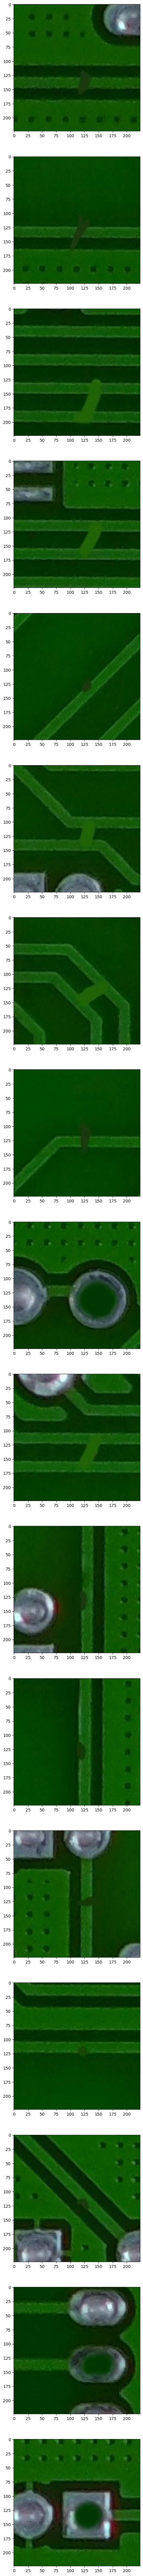

In [ ]:
defect_fig = plt.figure(figsize=[112,112])
for i in range(len(defect_)):
    plt.subplot(len(defect_),1,i+1)
    plt.imshow(defect_[i])
plt.show()

In [ ]:
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

model= Classifier()
load_params = torch.load("mymodel.pth")
model_params = model.state_dict()

model.eval()

with torch.no_grad():
  for i in range(len(defect_)):
   output = model(preprocess(defect_[i]).numpy)
   probabilities = torch.softmax(output, dim=1)
   max_prob, predicted_class = torch.max(probabilities, dim=1)
   print("Predicted class probabilities:", probabilities)
   print("Predicted class:", predicted_class)

TypeError: ignored